In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle
import re

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [44]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/data_open_trails.csv', parse_dates=True, index_col=0)

In [45]:
pd.set_option('display.max_rows', 500)

#### Drop the NaNs and inf scale data

In [46]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

In [47]:
ref_column = 'open_trails'

#### Scale the ref column

In [48]:
sc_skiers = scale_skiers(df, (0,100), ref_column)
sc_skiers = [round(crowd, 0) for crowd in sc_skiers]
df['open_trails'] = sc_skiers

### Create a training and holdout set

In [50]:
df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
df_h = df.ix[datetime.datetime(2012,11,1):datetime.datetime(2013,5,1)]
df_fut = df.ix[datetime.datetime(2011,5,1):]

## Forward selection

In [51]:
lin_regr = linear_model.LinearRegression()

In [52]:
features = list(df_tr.columns.values)
features.remove(ref_column)

In [53]:
X_tr = df_tr[features]
y_tr = df_tr[ref_column].values
X_h = df_h[features].values

In [54]:
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos][ref_column]
y_tr_apr = df_tr.iloc[apr_pos][ref_column]

In [55]:
leave_out = []
features_input = [f for f in features if f not in leave_out]

In [56]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 35, features_input, y_tr_mar, y_tr_apr, mar_pos, apr_pos)

Next best Feature:  ln_tot_snow , RMSE:  17.2 #: 1
Next best Feature:  days_since_start_sq , RMSE:  14.4 #: 2
Next best Feature:  days_since_start , RMSE:  12.8 #: 3
Next best Feature:  days_since_start_spring_break_sq , RMSE:  12.8 #: 4
Next best Feature:  6day_snow_tot_sq , RMSE:  12.8 #: 5
Next best Feature:  tot_snow_spring_break_sq , RMSE:  12.8 #: 6
Next best Feature:  2day_snow_tot_mon_sq , RMSE:  12.8 #: 7
Next best Feature:  new_24_mon_sqrt , RMSE:  12.8 #: 8
Next best Feature:  before_xmas_mon_sq , RMSE:  12.8 #: 9
Next best Feature:  2day_snow_tot_fri_sq , RMSE:  12.8 #: 10
Next best Feature:  2day_snow_tot_fri_sqrt , RMSE:  12.7 #: 11
Next best Feature:  thanksgiv_sqrt , RMSE:  12.6 #: 12
Next best Feature:  month_11 , RMSE:  12.9 #: 13
Next best Feature:  6day_snow_tot_xmas_sq , RMSE:  12.7 #: 14
Next best Feature:  6day_snow_tot_midweek , RMSE:  12.7 #: 15
Next best Feature:  ln_week_snow_tot_midweek , RMSE:  12.7 #: 16
Next best Feature:  6day_snow_tot_midweek_sq , RMSE:

In [ ]:
fs_features = ['ln_tot_snow', 'days_since_start_sq', 'days_since_start', 'days_since_start_spring_break_sq', '6day_snow_tot_sq', 'tot_snow_spring_break_sq', '2day_snow_tot_mon_sq', 'new_24_mon_sqrt', 'before_xmas_mon_sq', '2day_snow_tot_fri_sq', '2day_snow_tot_fri_sqrt', 'thanksgiv_sqrt', 'month_11', '6day_snow_tot_xmas_sq', '6day_snow_tot_midweek', 'ln_week_snow_tot_midweek', '6day_snow_tot_midweek_sq', 'month_2_sqrt', 'ln_2day_snow_tot_midweek', 'ln_tot_snow_fri', '2day_snow_tot_sat_sq', 'day_4_spring_break_sqrt', 'new_24_mon_sq', 'new_24_mon', 'thanksgiv_mon_sq', 'ln_3day_snow_tot_fri', 'month_11_fri_sq', '6day_snow_tot_fri_sq', '5day_snow_tot_fri', 'ln_4day_snow_tot_fri', '3day_snow_tot_sat_sq', 'before_xmas_sat_sqrt', 'days_since_start_fri_sq', 'day_4', 'month_2_fri_sqrt']

In [ ]:
plot_error_vs_features(RMSE, 'none', 'none')

In [ ]:
i = 1
while i < 6:
    num_good_feat = i
    df_reg = pd.concat([df_tr[ref_column], df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr[ref_column].values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], 1200, (15, 4), ref_column)
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], 1200, (15,4), ref_column)
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], 1200, (15,4), ref_column)
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,300), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

In [60]:
fs_features = ['ln_tot_snow', 'days_since_start_sq', 'days_since_start', 'days_since_start_spring_break_sq', '6day_snow_tot_sq', '2day_snow_tot_fri_sq', '6day_snow_tot_fri_sq', '6day_snow_tot_xmas_sq', 'tot_snow_spring_break_sq', '2day_snow_tot_fri_sqrt', '5day_snow_tot_fri', 'week_snow_tot_fri_sq', '2day_snow_tot_mon_sq', 'before_xmas_mon_sq', '6day_snow_tot_midweek', 'ln_week_snow_tot_midweek', 'thanksgiv_midweek', 'month_12_midweek_sqrt', 'thanksgiv_fri_sq', '3day_snow_tot_fri', 'week_snow_tot_sat_sq', 'ln_2day_snow_tot_sat', '2day_snow_tot_sat_sqrt', '6day_snow_tot_sat', 'thanksgiv_mon_sq', 'ln_3day_snow_tot_sat', 'ln_4day_snow_tot_sat', 'pres_day_fri_sqrt', 'day_4_spring_break_sq', 'ln_4day_snow_tot', 'new_24_mon_sqrt', '3day_snow_tot', 'day_5_spring_break_sqrt', 'month_2_fri', 'ln_new_24_fri']

In [61]:
num_feat = 3
best_features = fs_features[0:num_feat]
RMSE_H_lin, RMSE_CV, df_H_lin, df_cv_lin = get_holdout_RMSE(lin_regr, best_features, df_tr, df_h, ref_column)

CV RMSE: 12.8 ,  Holdout RMSE: 16.6


### Cross Validation Fit

In [62]:
ref_column

'open_trails'

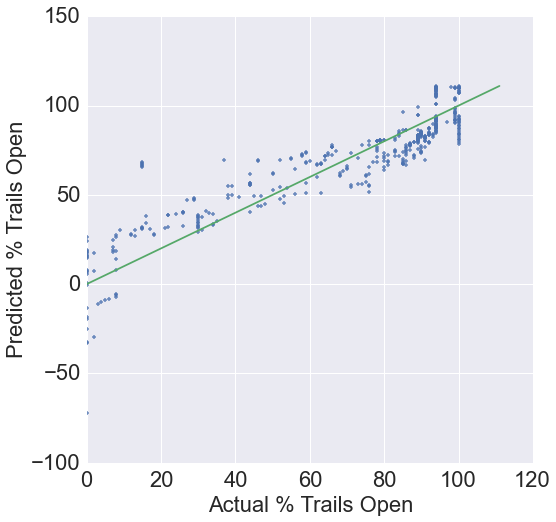

In [63]:
fitted_vs_ref_plot(df_cv_lin, ref_column, 'Predicted % Trails Open', 'Actual % Trails Open')

### Holdout Fit

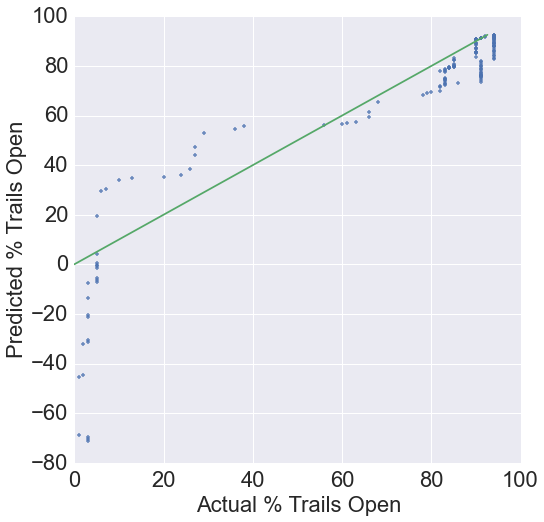

In [64]:
fitted_vs_ref_plot(df_H_lin, ref_column, 'Predicted % Trails Open', 'Actual % Trails Open')

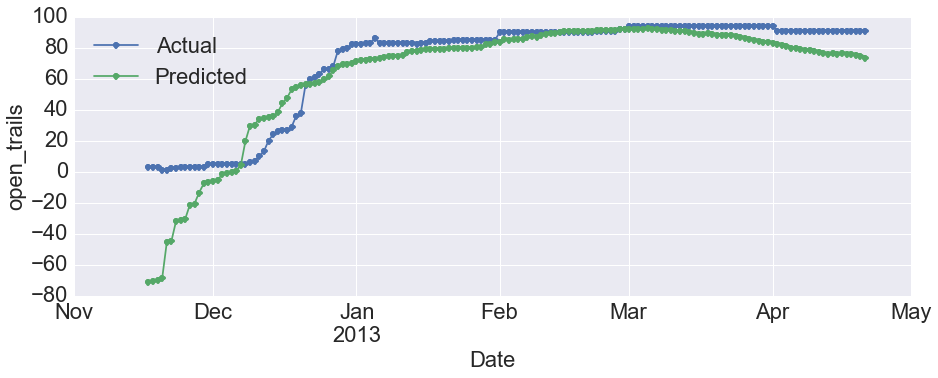

In [65]:
plot_fitted_and_ref_vs_time(df_H_lin, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], 1, (15,5), ref_column)

### Lasso

In [66]:
features = list(df.columns.values)
features.remove(ref_column)

In [67]:
X_tr, y_tr, X_h, y_h = find_training_and_hold_sets(df_tr, df_h, features, ref_column)

In [68]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-5, 10000000, 1.5)

Best Lambda: 6.0


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


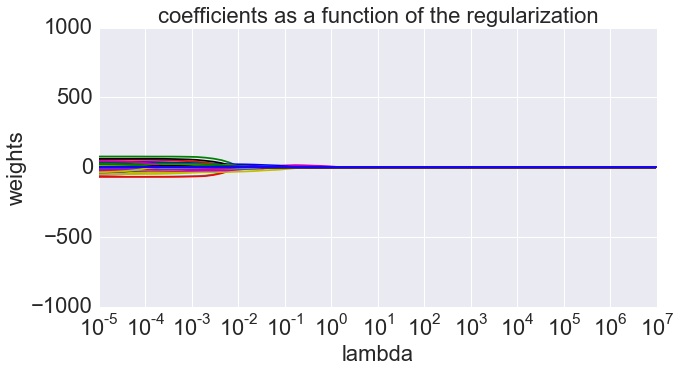

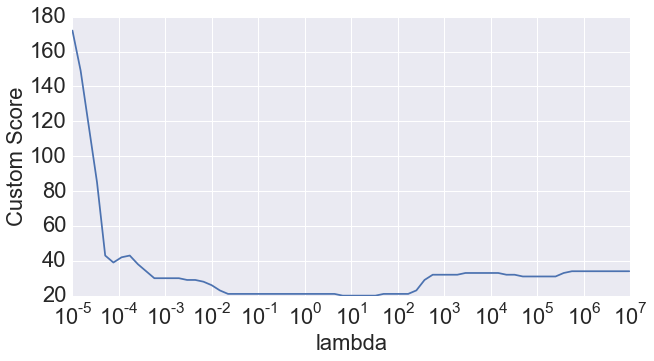

In [69]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda, (-1000,1000))

#### Find cross-validation and holdout RMSE

In [70]:
clf = linear_model.Lasso(alpha=best_lambda)

In [71]:
RMSE_ls_H, RMSE_ls_CV, df_ls_hold, df_ls_cv = get_holdout_RMSE(clf, features, df_tr, df_h, ref_column)

CV RMSE: 20.4 ,  Holdout RMSE: 9.8


#### Plot the holdout lasso prediction vs the reference data

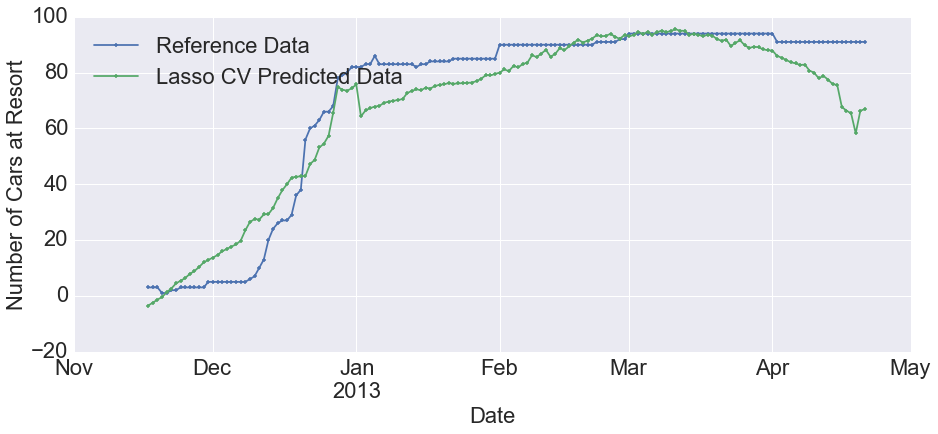

In [72]:
plot_lasso_and_ref_vs_time(df_ls_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])

## Random Forest

In [73]:
features = fs_features

In [74]:
X_tr = df_tr[features]
y_tr = df_tr[ref_column].values
X_h = df_h[features]
y_h = df_h[ref_column].values

#### Fit the random forest regressor and find cross-validation stats

In [75]:
rfr = RandomForestRegressor(n_estimators = 500, oob_score = True, n_jobs = -1)

In [76]:
RMSE_rf_H, RMSE_rf_CV, df_rf_hold, df_rf_cv = get_holdout_RMSE(rfr, features, df_tr, df_h, ref_column)

CV RMSE: 12.5 ,  Holdout RMSE: 4.8


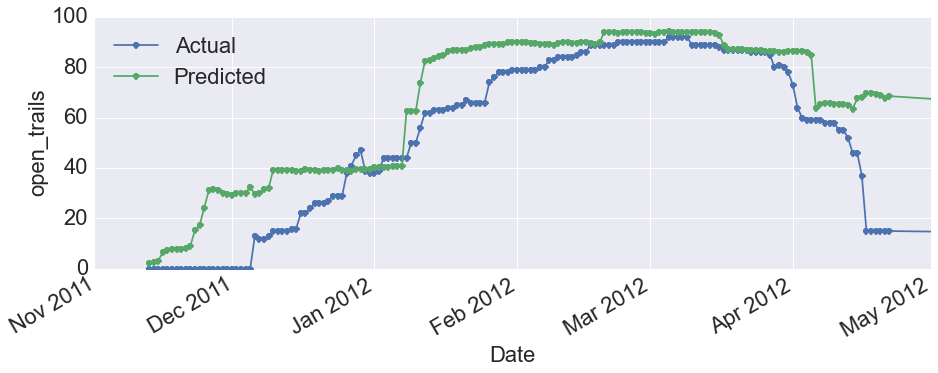

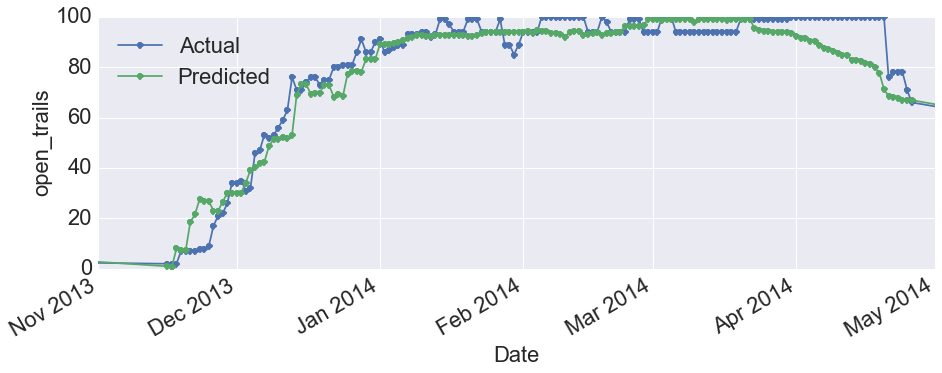

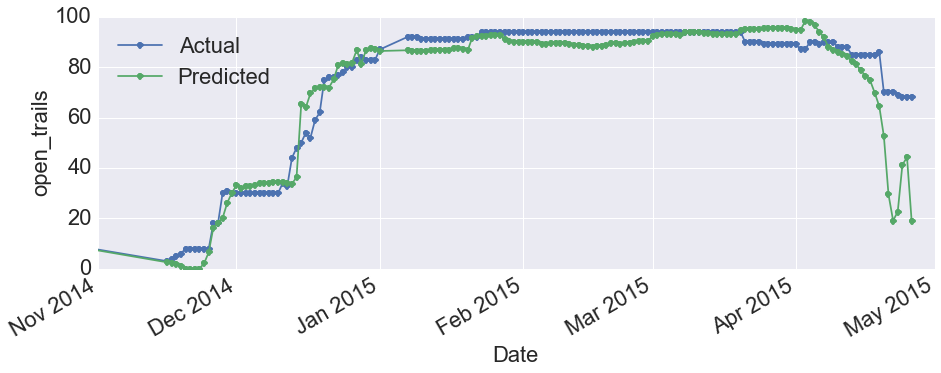

In [77]:
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], RMSE_rf_CV, (15,5), ref_column)
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], RMSE_rf_CV, (15,5), ref_column)
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], RMSE_rf_CV, (15,5), ref_column)

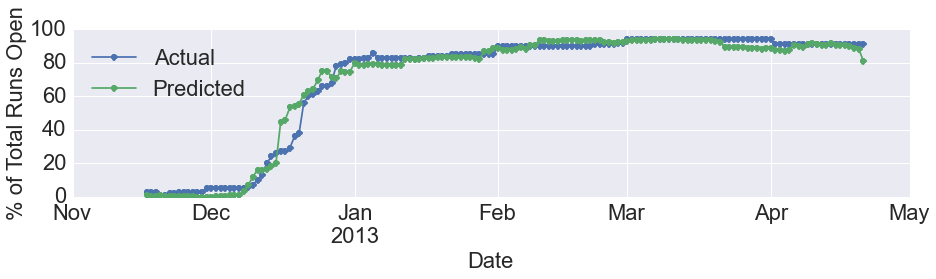

In [78]:
plot_fitted_and_ref_vs_time(df_rf_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], 1200, (15,3), '% of Total Runs Open')

### Get bootstrap estimates of confidence intervals to the dataframe.

In [82]:
X_fut = df_fut[fs_features]
df_fut = df.ix[datetime.datetime(2015,5,1):]
df_cv = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,5,1)]
df_pred = run_bootstrap_model(df_cv, rfr, fs_features, X_fut, ref_column)
df_fut = add_pred_and_conf_int_to_df(df_pred, df_fut)

#### Add a 'day of week' column to the df.

In [92]:
day_of_week = []
for idx, day in df_fut.iterrows():
    day_of_week.append(idx.weekday())
    
df_fut['day_of_week'] = day_of_week

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Export Data

In [93]:
df_fut.to_csv('../webpage_ski/df_runs_open.csv')